In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.arima.model as sm_arima
from datetime import datetime
import statsmodels.api as sm
import plotly.express as px
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller


In [154]:
df = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [155]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [156]:
df.rename(columns={'PJME_MW': 'Energy Consumption'}, inplace=True)

In [157]:
df

,Energy Consumption
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


### Manage Duplicate

In [158]:
# Identify Duplicate Indices
duplicate_index = df[df.index.duplicated()]
df.loc[duplicate_index.index.values, :]

,Energy Consumption
Datetime,
2014-11-02 02:00:00,22935.0
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21567.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,20795.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,21236.0
2017-11-05 02:00:00,20666.0


In [159]:
# Replace Duplicates with Mean Value
df = df.groupby('Datetime').agg(np.mean)

# Set DatetimeIndex Frequency
df = df.asfreq('H')
df

,Energy Consumption
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


### Impute Missing Values

In [160]:
# Determine # of Missing Values
print('# of Missing Energy Consumption Values: {}'.format(len(df[df['Energy Consumption'].isna()])))

# of Missing Energy Consumption Values: 30


In [161]:
# Impute Missing Values
df['Energy Consumption'] = df['Energy Consumption'].interpolate(limit_area='inside', limit=None)

In [162]:
# Check if any null values exist in the DataFrame
if df.isnull().any().any():
    print("Null values exist in the DataFrame")
else:
    print("No null values found in the DataFrame")

No null values found in the DataFrame


In [163]:
df_orig = df

### Create Features

In [164]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayofWeek'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['DayOfMonth'] = df.index.day
    df['WeekOfYear'] = df.index.isocalendar().week
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    return df

df = create_features(df)

### Basic Analysis - Visualizations

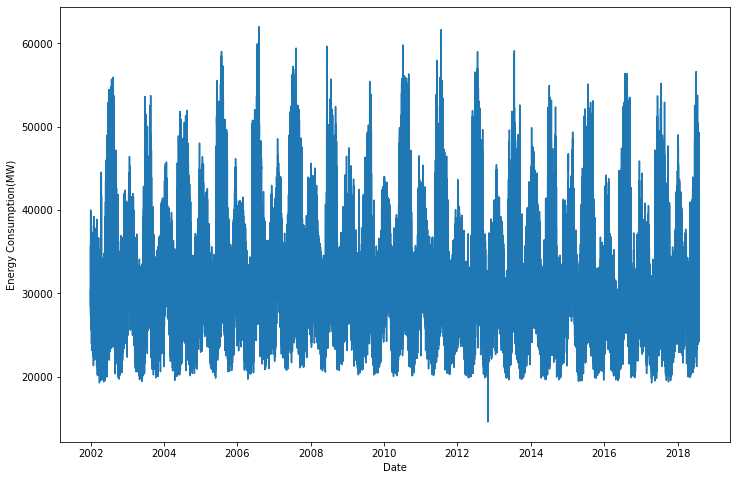

In [122]:
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Energy Consumption'])
plt.xlabel('Date')
plt.ylabel('Energy Consumption(MW)')
plt.show()


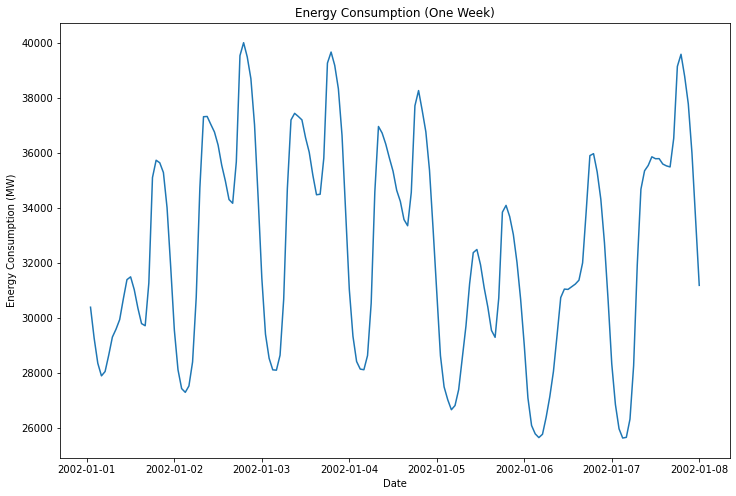

In [123]:
# One-Week Slice

WEEK_END_INDEX = 7*24
plt.figure(figsize=(12, 8))
plt.plot(df.index[:WEEK_END_INDEX], df['Energy Consumption'][:WEEK_END_INDEX])
plt.title('Energy Consumption (One Week)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.show()

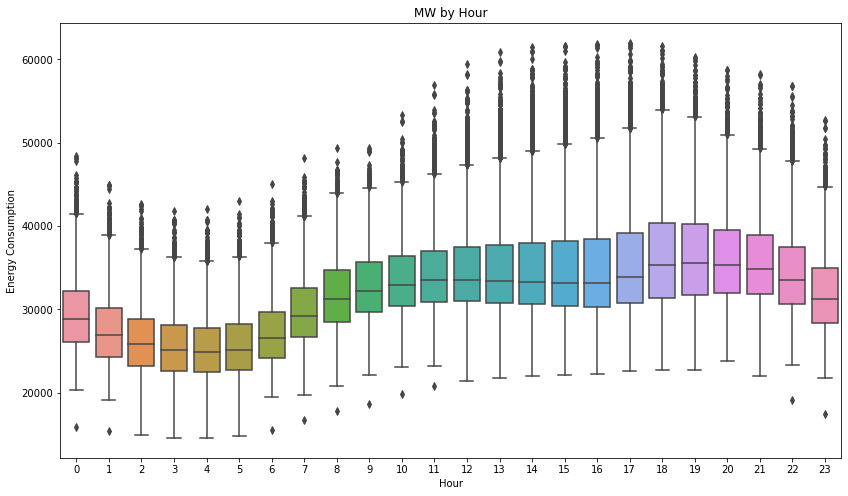

In [124]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df, x='Hour', y='Energy Consumption')
ax.set_title('MW by Hour')
plt.show()

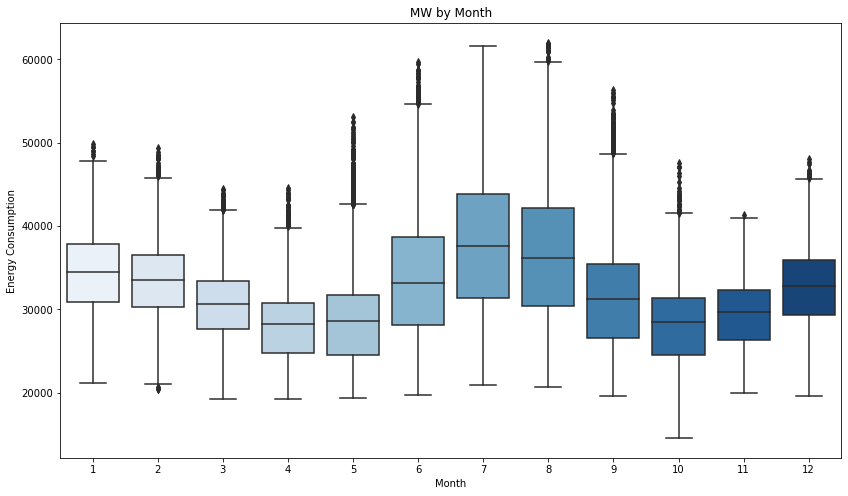

In [125]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df, x='Month', y='Energy Consumption', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [129]:
df

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


### Seasonal Plot

In [18]:
df = df.copy()
year_group = df.groupby(['Year', 'Month']).mean().reset_index()
year_group

,Year,Month,Energy Consumption,Hour,DayofWeek,Quarter,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
0,2002,1,31075.399731,11.515478,2.905787,1.0,16.020188,16.020188,2.873486,16.500000
1,2002,2,30239.166667,11.500000,3.000000,1.0,45.500000,14.500000,7.071429,45.979167
2,2002,3,28875.256720,11.500000,3.193548,1.0,75.000000,16.000000,11.258065,75.479167
3,2002,4,28529.284028,11.500000,2.833333,2.0,105.500000,15.500000,15.666667,105.979167
4,2002,5,28073.653226,11.500000,3.000000,2.0,136.000000,16.000000,20.0,136.479167
...,...,...,...,...,...,...,...,...,...,...
195,2018,4,27353.266667,11.500000,3.000000,2.0,105.500000,15.500000,15.5,105.979167
196,2018,5,28599.951613,11.500000,2.903226,2.0,136.000000,16.000000,19.870968,136.479167
197,2018,6,32014.469444,11.500000,3.100000,2.0,166.500000,15.500000,24.2,166.979167
198,2018,7,36696.737903,11.500000,2.935484,3.0,197.000000,16.000000,28.580645,197.479167


In [19]:
df

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


In [20]:
years = df['Year']
years

Datetime
2002-01-01 01:00:00    2002
2002-01-01 02:00:00    2002
2002-01-01 03:00:00    2002
2002-01-01 04:00:00    2002
2002-01-01 05:00:00    2002
                       ... 
2018-08-02 20:00:00    2018
2018-08-02 21:00:00    2018
2018-08-02 22:00:00    2018
2018-08-02 23:00:00    2018
2018-08-03 00:00:00    2018
Freq: H, Name: Year, Length: 145392, dtype: int64

In [21]:
years = df['Year'].unique()
NUM_COLORS = len(years)

In [22]:
years

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

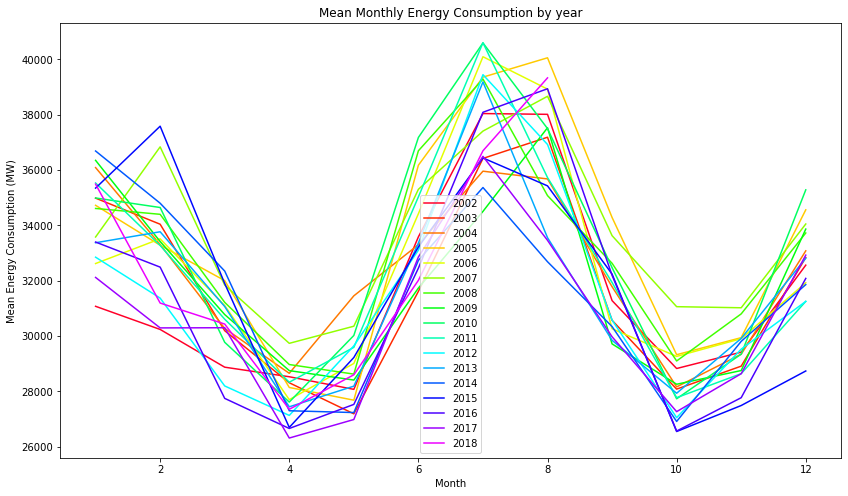

In [23]:


cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df1 = year_group[year_group['Year'] == y]
    #rolling_mean = df.rolling(window=7*24).mean()
    plt.plot(df1['Month'], df1['Energy Consumption'])

plt.title('Mean Monthly Energy Consumption by year')
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(df.Year.unique())
plt.show()

### Moving Average (Smoothing)

In [24]:
df

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


In [25]:
MONTH_PERIOD = 24*30
MIDYEAR_PERIOD = 24*182
YEAR_PERIOD = 24*365

month_roll = df.rolling(MONTH_PERIOD).mean()
midyear_roll = df.rolling(MIDYEAR_PERIOD).mean()
year_roll = df.rolling(YEAR_PERIOD).mean()

In [26]:
month_roll = df.rolling(MONTH_PERIOD).mean()
month_roll.tail(20)

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2018-08-02 05:00:00,36326.775000,11.5,2.916667,3.0,7.041667,2018.0,198.750000,16.458333,28.833333,199.229167
2018-08-02 06:00:00,36321.862500,11.5,2.919444,3.0,7.043056,2018.0,198.791667,16.456944,28.838889,199.270833
2018-08-02 07:00:00,36316.894444,11.5,2.922222,3.0,7.044444,2018.0,198.833333,16.455556,28.844444,199.312500
2018-08-02 08:00:00,36311.223611,11.5,2.925000,3.0,7.045833,2018.0,198.875000,16.454167,28.850000,199.354167
2018-08-02 09:00:00,36304.459722,11.5,2.927778,3.0,7.047222,2018.0,198.916667,16.452778,28.855556,199.395833
2018-08-02 10:00:00,36296.315278,11.5,2.930556,3.0,7.048611,2018.0,198.958333,16.451389,28.861111,199.437500
2018-08-02 11:00:00,36287.027778,11.5,2.933333,3.0,7.050000,2018.0,199.000000,16.450000,28.866667,199.479167
2018-08-02 12:00:00,36276.404167,11.5,2.936111,3.0,7.051389,2018.0,199.041667,16.448611,28.872222,199.520833
2018-08-02 13:00:00,36264.944444,11.5,2.938889,3.0,7.052778,2018.0,199.083333,16.447222,28.877778,199.562500


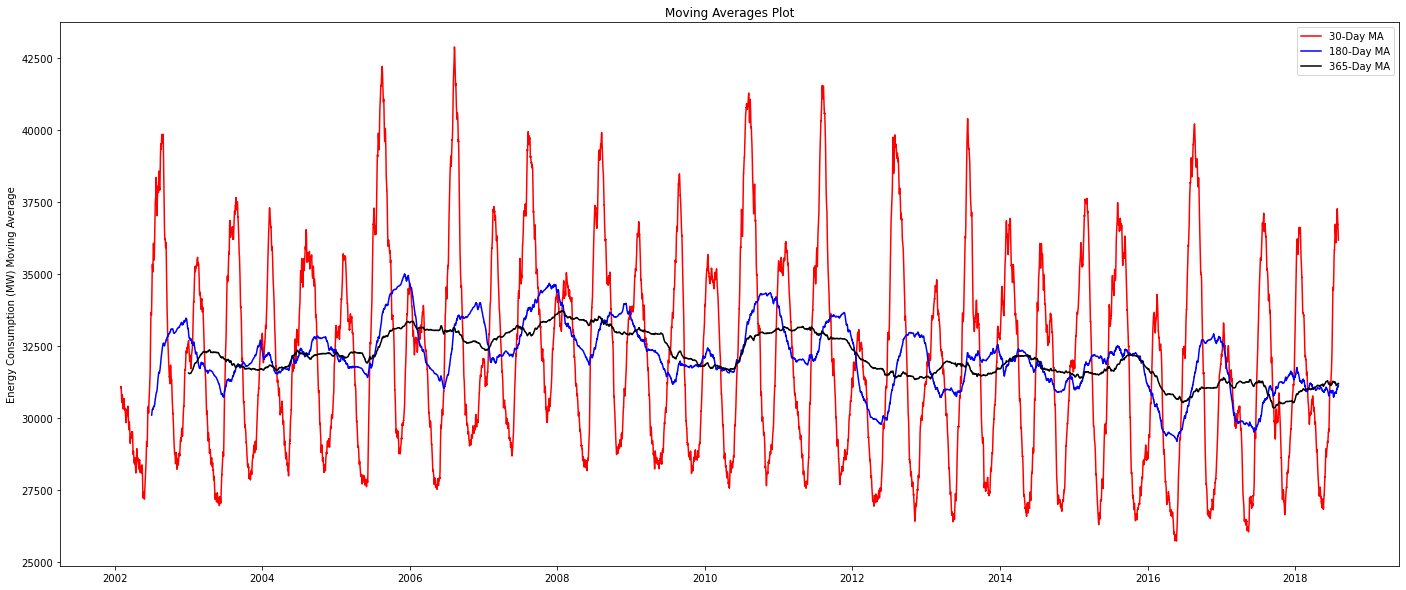

In [27]:


fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll['Energy Consumption'], color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll['Energy Consumption'], color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll['Energy Consumption'], color='black', label='365-Day MA')
plt.title('Moving Averages Plot')
plt.ylabel('Energy Consumption (MW) Moving Average')
plt.legend()
plt.show()

### Seasonal Subplots

Seasonal trends refer to recurring patterns or variations in a dataset that repeat over specific time intervals, typically within a year. These patterns often correspond to changes in natural or human factors related to the seasons, such as weather, holidays, or economic cycles.

Analyzing seasonal trends is important in various fields, including economics, finance, marketing, and environmental science. By understanding and identifying seasonal patterns in data, one can gain insights into the underlying factors that influence the observed variations. This knowledge can be valuable for decision-making, forecasting, and planning.

In the context of energy consumption, analyzing seasonal trends can provide valuable information about how energy usage varies throughout the year. It helps identify patterns related to climate conditions, changes in daylight hours, heating or cooling demands, holiday-related fluctuations, and other factors that affect energy consumption patterns. This information can be useful for energy providers, policymakers, and researchers to optimize energy production, plan for peak demand periods, develop energy conservation strategies, and evaluate the effectiveness of energy management initiatives.

Visualizing seasonal trends through plots or charts allows for a better understanding of the cyclical patterns in the data. It enables the identification of recurring patterns, anomalies, and potential correlations with other variables. By analyzing these trends, stakeholders can make informed decisions and take appropriate actions based on the seasonality of the data.

In [28]:
df

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


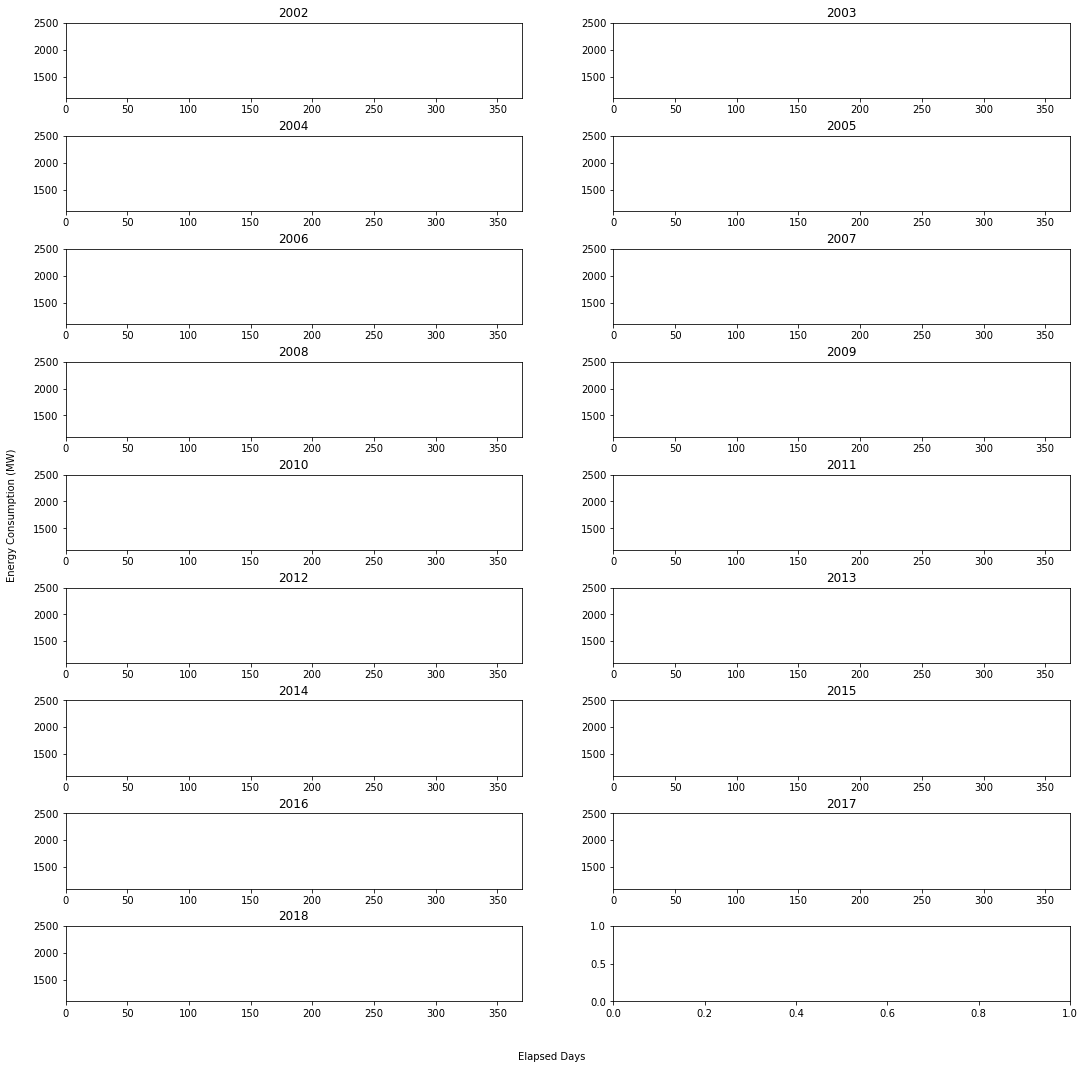

In [193]:
num_rows = 9
num_cols = 2
year_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))
years = df['Year'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        if year_index < len(years):
            df2 = df[df['Year'] == years[year_index]]
            rolling_mean = df2['Energy Consumption'].rolling(window=7*24).mean()
            axes[i][j].plot(df2['DayOfYearFloat'], rolling_mean.values)
            axes[i][j].set_title(str(years[year_index]))
            axes[i][j].set_ylim(1100, 2500)
            axes[i][j].set_xlim(0, 370)
            year_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()


In [30]:
df2

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2018-01-01 00:00:00,39928.0,0,0,1,1,2018,1,1,1,1.000000
2018-01-01 01:00:00,38925.0,1,0,1,1,2018,1,1,1,1.041667
2018-01-01 02:00:00,38298.0,2,0,1,1,2018,1,1,1,1.083333
2018-01-01 03:00:00,37808.0,3,0,1,1,2018,1,1,1,1.125000
2018-01-01 04:00:00,37742.0,4,0,1,1,2018,1,1,1,1.166667
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


## Seasonal Decomposition
### Estimated Daily Amplitude

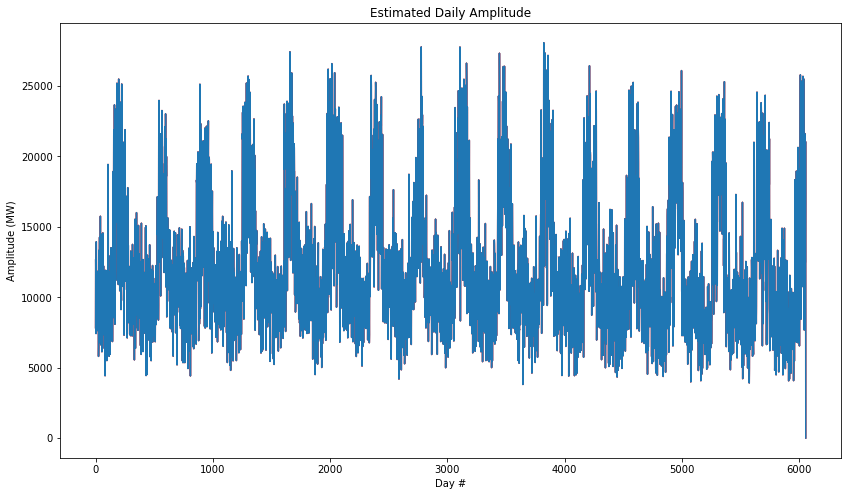

In [31]:
max_daily_vals = df.groupby(['Year', 'DayOfYear']).max()['Energy Consumption'].values
min_daily_vals = df.groupby(['Year', 'DayOfYear']).min()['Energy Consumption'].values
daily_amp = max_daily_vals - min_daily_vals
fig = plt.figure(figsize=(14, 8))
plt.plot(daily_amp, color='red')
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Amplitude (MW)')
plt.title('Estimated Daily Amplitude')
plt.show()

### Multiplicative Decomposition

Time Series = Trend Component × Seasonal Component × Residual Component


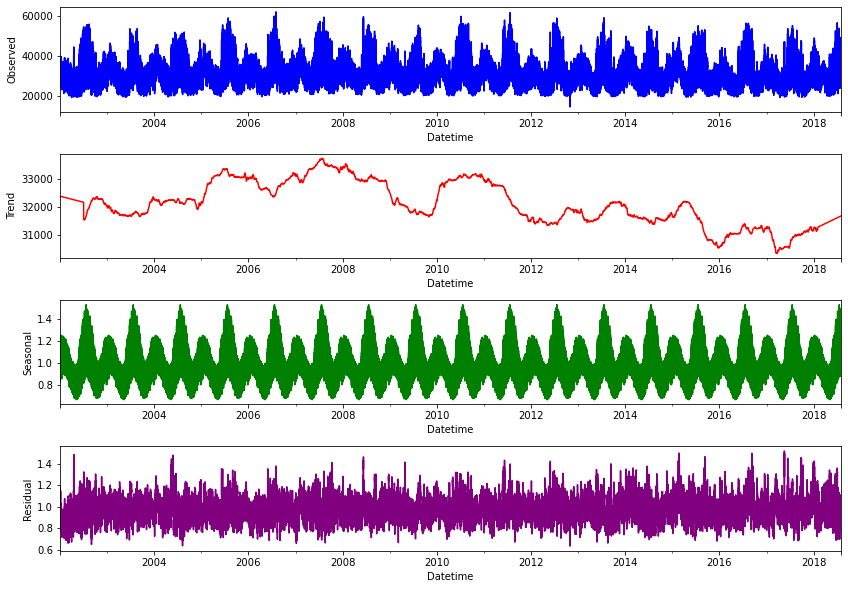

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ANNUAL_PERIOD = 365 * 24
mult_decomp = seasonal_decompose(df['Energy Consumption'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
colors = ['blue', 'red', 'green', 'purple']

# Adjust the size of each subplot
fig.subplots_adjust(hspace=0.4)

mult_decomp.observed.plot(ax=axes[0], color=colors[0])
axes[0].set_ylabel('Observed')

mult_decomp.trend.plot(ax=axes[1], color=colors[1])
axes[1].set_ylabel('Trend')

mult_decomp.seasonal.plot(ax=axes[2], color=colors[2])
axes[2].set_ylabel('Seasonal')

mult_decomp.resid.plot(ax=axes[3], color=colors[3])
axes[3].set_ylabel('Residual')

plt.show()


### Stationarity

In [33]:
# Augmented Dickey Fuller (ADF) Test

adf_result = adfuller(df['Energy Consumption'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -19.96459393184059
p-value: 0.0


A p-value of zero or very close to zero may indicate a strong rejection of the null hypothesis, but it does not necessarily imply stationarity.

### Differencing

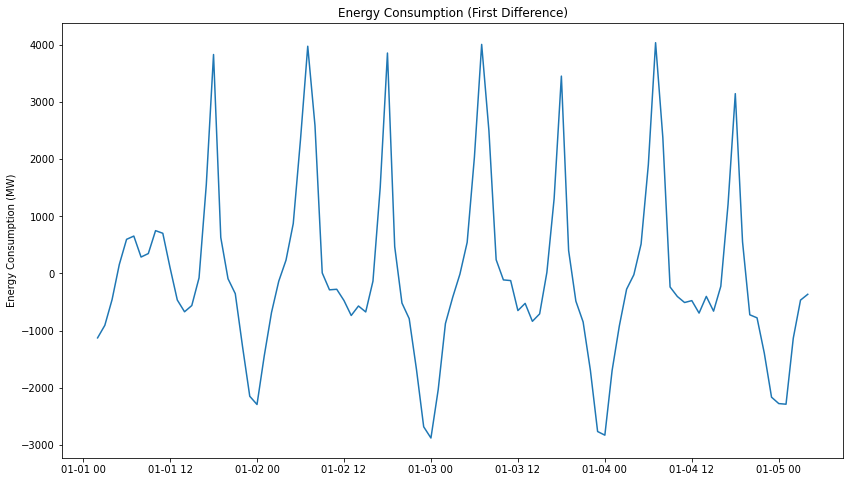

In [42]:
# First Difference (First 100 Values)
df['first_difference'] = df['Energy Consumption'] - df['Energy Consumption'].shift(1)
fig = plt.figure(figsize=(14, 8))
plt.plot(df.index[:100], df['first_difference'][:100])
plt.title('Energy Consumption (First Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

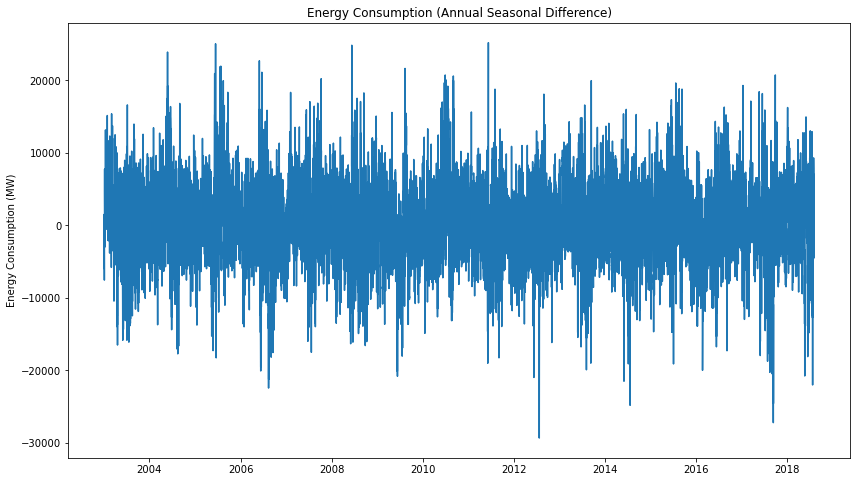

In [43]:
# Annual Seasonal Difference (First 1000 Values)
ANNUAL_SHIFT = 24*365

df['seasonal_difference'] = df['Energy Consumption'] - df['Energy Consumption'].shift(ANNUAL_SHIFT)
fig = plt.figure(figsize=(14, 8))
plt.plot(df.index, df['seasonal_difference'])
plt.title('Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [44]:
adf_result = adfuller(df['seasonal_difference'][ANNUAL_SHIFT:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -28.037258644351677
p-value: 0.0


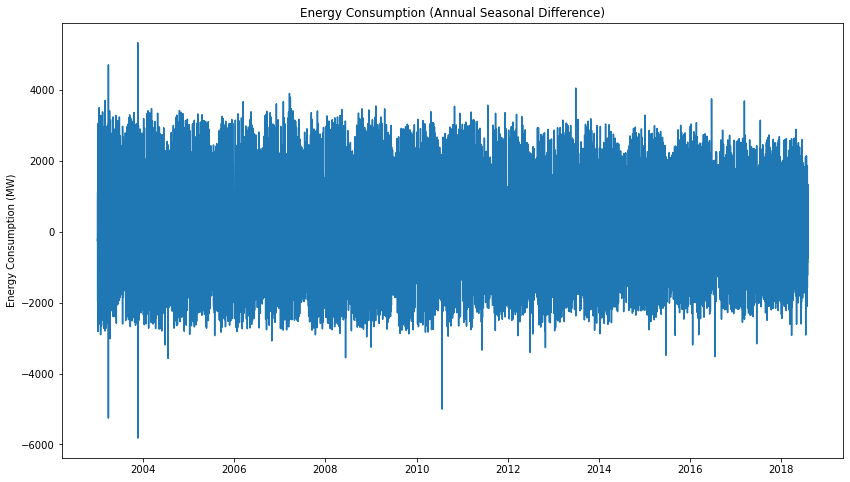

In [45]:
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(ANNUAL_SHIFT)
fig = plt.figure(figsize=(14, 8))
plt.plot(df.index, df['seasonal_first_difference'])
plt.title('Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [46]:
adf_result = adfuller(df['seasonal_first_difference'][ANNUAL_SHIFT+1:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -55.15109886173633
p-value: 0.0


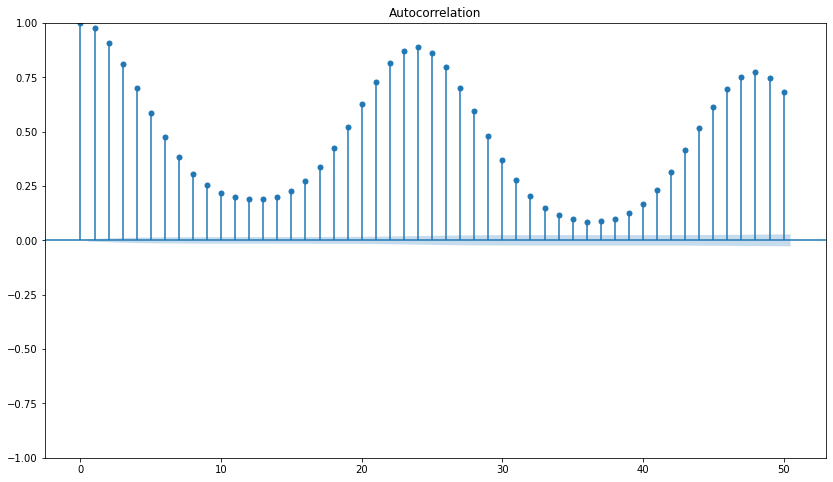

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Set the figure size directly when creating subplots
fig, ax = plt.subplots(figsize=(14, 8))

# Plot autocorrelation
plot_acf(df['Energy Consumption'], lags=50, ax=ax)

# Add labels, title, etc.

plt.show()


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


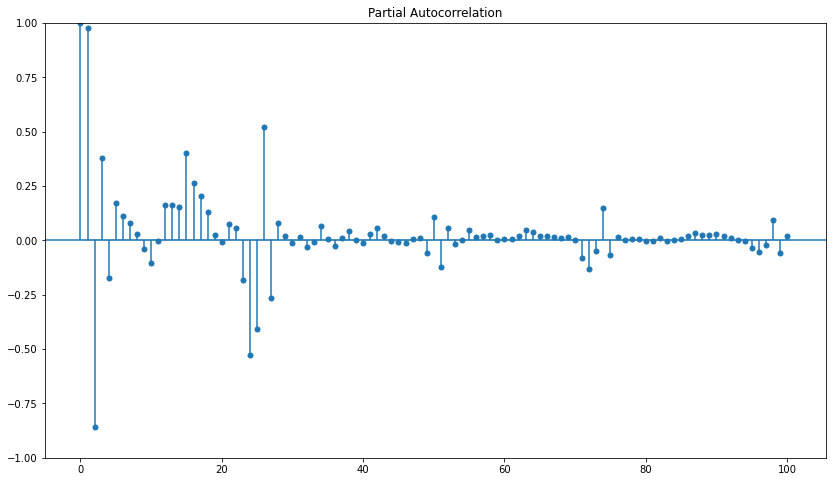

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(14, 8))
plot_pacf(df['Energy Consumption'], lags=100, ax=ax)
plt.show()

### Baseline ARIMA Models

RMSE Score on Test set: 1842.51


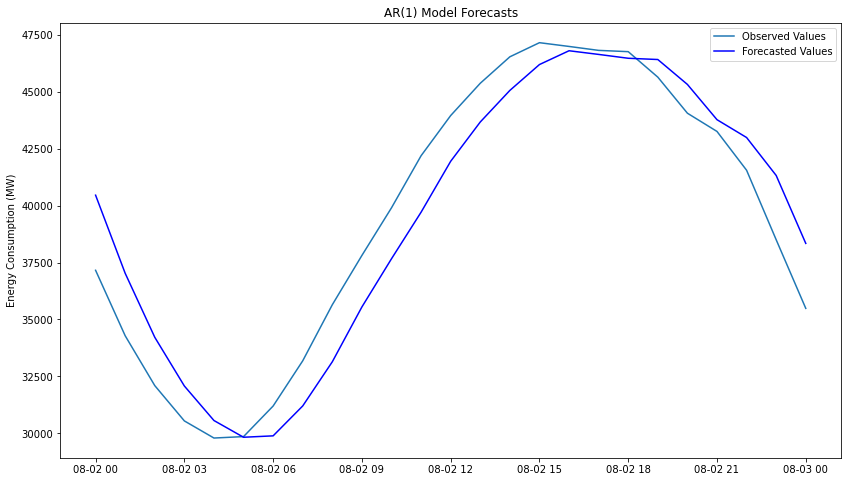

In [198]:
# Load the dataset into a pandas DataFrame (assuming 'df' is the DataFrame)
# Assuming 'Energy Consumption' column exists and has a proper datetime index

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()


RMSE Score on Test set: 1866.22


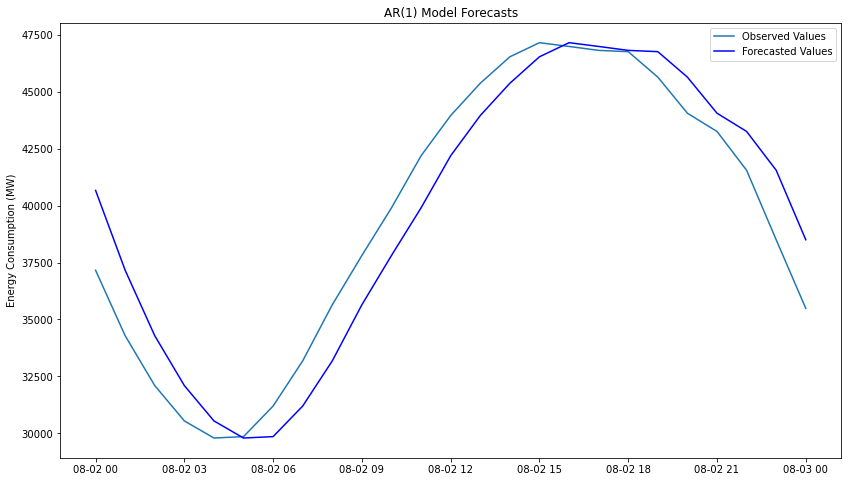

In [199]:
# Load the dataset into a pandas DataFrame (assuming 'df' is the DataFrame)
# Assuming 'Energy Consumption' column exists and has a proper datetime index

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE Score on Test set: 5156.50


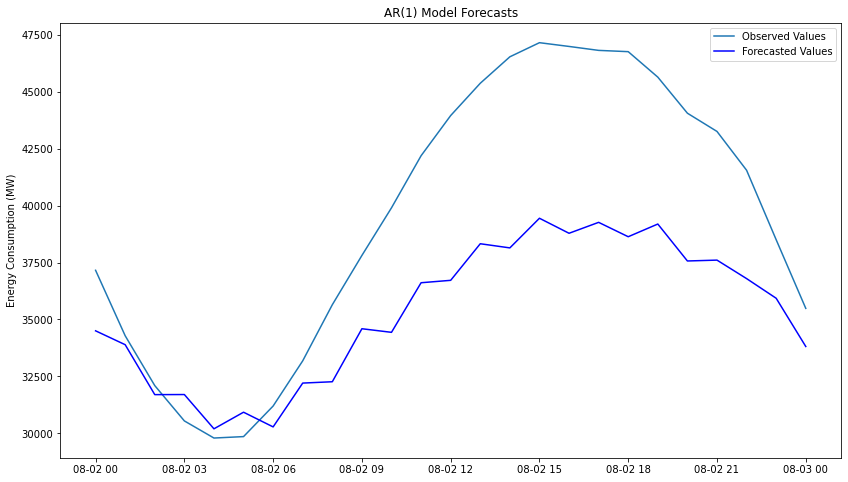

In [200]:
# Load the dataset into a pandas DataFrame (assuming 'df' is the DataFrame)
# Assuming 'Energy Consumption' column exists and has a proper datetime index

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(0, 0, 1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

RMSE Score on Test set: 545.62


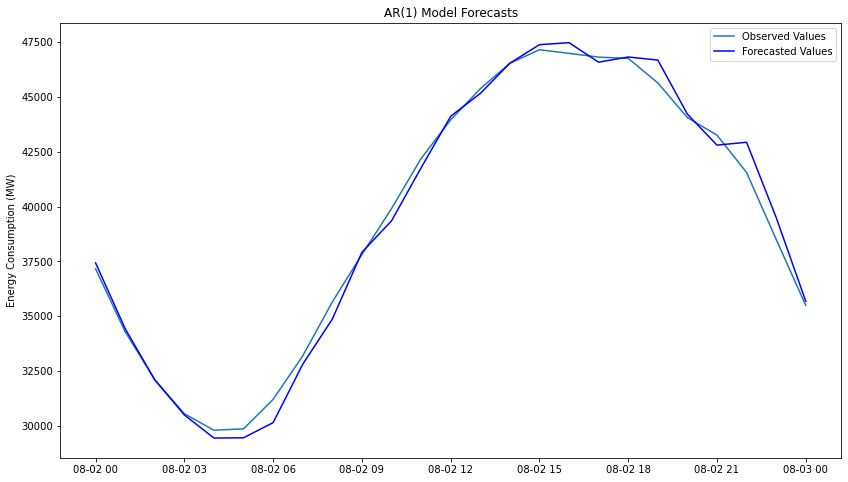

In [201]:
# Load the dataset into a pandas DataFrame (assuming 'df' is the DataFrame)
# Assuming 'Energy Consumption' column exists and has a proper datetime index

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarnin

RMSE Score on Test set: 473.62


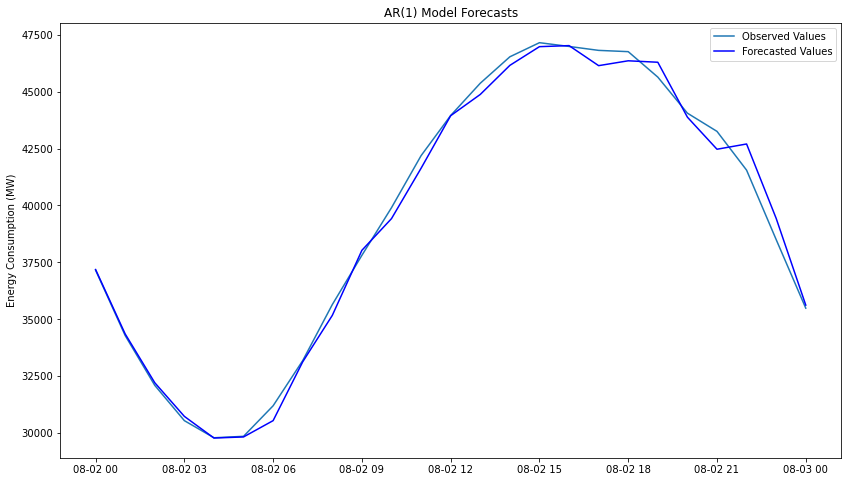

In [202]:
# Load the dataset into a pandas DataFrame (assuming 'df' is the DataFrame)
# Assuming 'Energy Consumption' column exists and has a proper datetime index

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('AR(1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [195]:
ar_pred_series

Datetime
2018-08-02 00:00:00    37183.885626
2018-08-02 01:00:00    34353.125233
2018-08-02 02:00:00    32209.613865
2018-08-02 03:00:00    30730.739546
2018-08-02 04:00:00    29778.925575
2018-08-02 05:00:00    29826.925721
2018-08-02 06:00:00    30544.005806
2018-08-02 07:00:00    33129.417755
2018-08-02 08:00:00    35169.285124
2018-08-02 09:00:00    38029.344968
2018-08-02 10:00:00    39421.895053
2018-08-02 11:00:00    41635.990367
2018-08-02 12:00:00    43945.892495
2018-08-02 13:00:00    44879.379164
2018-08-02 14:00:00    46157.028058
2018-08-02 15:00:00    46979.454733
2018-08-02 16:00:00    47025.552210
2018-08-02 17:00:00    46144.777456
2018-08-02 18:00:00    46358.130809
2018-08-02 19:00:00    46294.450057
2018-08-02 20:00:00    43880.807940
2018-08-02 21:00:00    42471.155245
2018-08-02 22:00:00    42702.118461
2018-08-02 23:00:00    39432.341246
2018-08-03 00:00:00    35620.597933
Freq: H, dtype: float64

In [196]:
test_series

Datetime
2018-08-02 00:00:00    37158.0
2018-08-02 01:00:00    34283.0
2018-08-02 02:00:00    32094.0
2018-08-02 03:00:00    30543.0
2018-08-02 04:00:00    29791.0
2018-08-02 05:00:00    29854.0
2018-08-02 06:00:00    31197.0
2018-08-02 07:00:00    33182.0
2018-08-02 08:00:00    35645.0
2018-08-02 09:00:00    37810.0
2018-08-02 10:00:00    39902.0
2018-08-02 11:00:00    42189.0
2018-08-02 12:00:00    43954.0
2018-08-02 13:00:00    45372.0
2018-08-02 14:00:00    46534.0
2018-08-02 15:00:00    47154.0
2018-08-02 16:00:00    46989.0
2018-08-02 17:00:00    46816.0
2018-08-02 18:00:00    46760.0
2018-08-02 19:00:00    45641.0
2018-08-02 20:00:00    44057.0
2018-08-02 21:00:00    43256.0
2018-08-02 22:00:00    41552.0
2018-08-02 23:00:00    38500.0
2018-08-03 00:00:00    35486.0
Freq: H, Name: Energy Consumption, dtype: float64

In [197]:
score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 473.62


## Gradient Boosting Model

In [165]:
df_orig

,Energy Consumption
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


## Train / Test Split

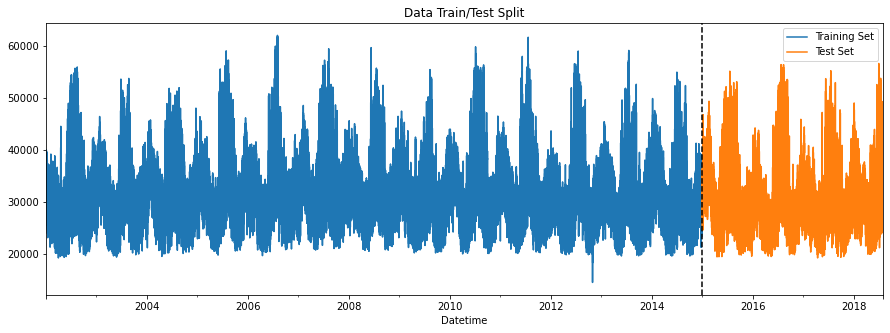

In [166]:
train = df_orig.loc[df_orig.index < '01-01-2015']
test = df_orig.loc[df_orig.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [167]:
train

,Energy Consumption
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2014-12-31 19:00:00,38906.0
2014-12-31 20:00:00,37772.0
2014-12-31 21:00:00,36602.0


In [168]:
test

,Energy Consumption
Datetime,
2015-01-01 00:00:00,32802.0
2015-01-01 01:00:00,31647.0
2015-01-01 02:00:00,30755.0
2015-01-01 03:00:00,30189.0
2015-01-01 04:00:00,29890.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


In [170]:
train = create_features(train)
test = create_features(test)

In [171]:
train

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,38906.0,19,2,4,12,2014,365,31,1,365.791667
2014-12-31 20:00:00,37772.0,20,2,4,12,2014,365,31,1,365.833333
2014-12-31 21:00:00,36602.0,21,2,4,12,2014,365,31,1,365.875000


In [172]:
test

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,1.000000
2015-01-01 01:00:00,31647.0,1,3,1,1,2015,1,1,1,1.041667
2015-01-01 02:00:00,30755.0,2,3,1,1,2015,1,1,1,1.083333
2015-01-01 03:00:00,30189.0,3,3,1,1,2015,1,1,1,1.125000
2015-01-01 04:00:00,29890.0,4,3,1,1,2015,1,1,1,1.166667
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


### Create The Model

In [173]:


FEATURES = ['DayOfYear', 'Hour', 'DayofWeek', 'Quarter', 'Month', 'Year']
TARGET = 'Energy Consumption'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### XGBoost Model

In [174]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:38:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32603.50509	validation_1-rmse:31657.42613
[100]	validation_0-rmse:12582.26816	validation_1-rmse:11746.02570
[200]	validation_0-rmse:5836.09015	validation_1-rmse:5366.22689
[300]	validation_0-rmse:3921.26576	validation_1-rmse:4023.63509
[400]	validation_0-rmse:3446.18773	validation_1-rmse:3852.78794
[500]	validation_0-rmse:3286.47496	validation_1-rmse:3808.70584
[600]	validation_0-rmse:3204.88156	validation_1-rmse:3777.27241
[700]	validation_0-rmse:3151.42501	validation_1-rmse:3756.80131
[800]	validation_0-rmse:3111.72340	validation_1-rmse:3738.42921
[900]	validation_0-rmse:3081.06734	validation_1-rmse:3729.20725
[999]	validation_0-rmse:3054.07319	validation_1-rmse:3726.78424


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Feature Importance Analysis

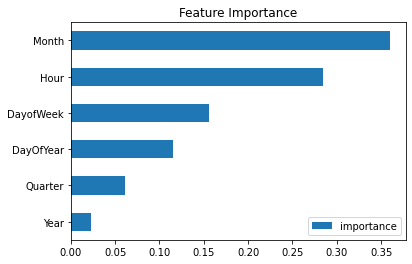

In [175]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Predictions using the XGBoost library

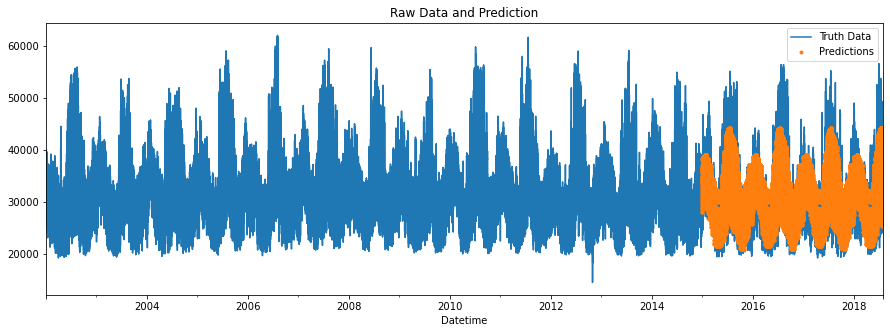

In [187]:
test['prediction'] = reg.predict(X_test)
df_orig = df_orig.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_orig[['Energy Consumption']].plot(figsize=(15, 5))
df_orig['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [177]:
test['prediction']

Datetime
2015-01-01 00:00:00    30597.498047
2015-01-01 01:00:00    29506.939453
2015-01-01 02:00:00    28605.074219
2015-01-01 03:00:00    28168.035156
2015-01-01 04:00:00    28087.707031
                           ...     
2018-08-02 20:00:00    42655.664062
2018-08-02 21:00:00    42505.281250
2018-08-02 22:00:00    40780.957031
2018-08-02 23:00:00    37889.957031
2018-08-03 00:00:00    31651.279297
Freq: H, Name: prediction, Length: 31441, dtype: float32

In [188]:
df_orig = create_features(df_orig)
df_orig

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat,prediction
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333,42655.664062
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000,42505.281250
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667,40780.957031


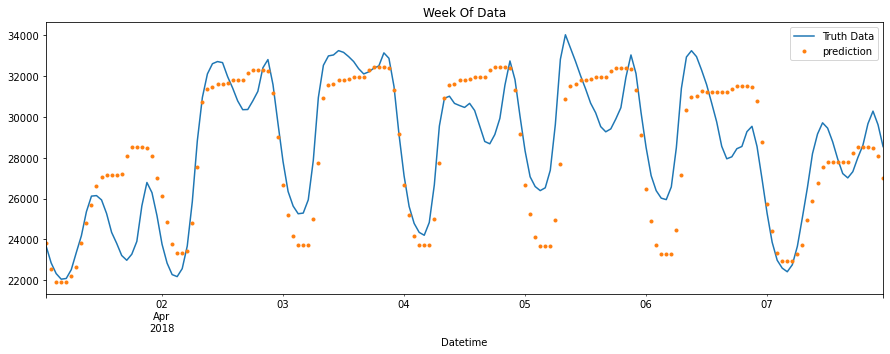

In [189]:
ax = df_orig.loc[(df_orig.index > '04-01-2018') & (df_orig.index < '04-08-2018')]['Energy Consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df_orig.loc[(df_orig.index > '04-01-2018') & (df_orig.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction'])
plt.show()

### Scoring with Root Mean Squared Error (RMSE)

In [194]:
score = np.sqrt(mean_squared_error(test['Energy Consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.32


### Error Calculation

In [191]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12859.865397
2016-08-14    12793.324544
2016-09-10    11327.278809
2015-02-20    11000.332194
2016-09-09    10842.475260
2018-01-06    10462.798910
2016-08-12    10151.880371
2015-02-21     9897.954427
2015-02-16     9814.756592
2018-01-07     9686.674642
Name: error, dtype: float64